In [1]:
# load data 
import glob
import pathlib 
import numpy as np
import cv2
import torch
import math

from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torch.nn.functional as F
import jnu as J
from tqdm.auto import tqdm
import torchvision

DATASET = 1 # ped 1
TRAIN = True
STAGE = 'Train' if TRAIN else 'Test'

PATH = f"~/.data/UCSD/UCSDped{DATASET}/{STAGE}/"
PATH = str(pathlib.Path(PATH).expanduser().resolve())

def extract_image_patches(x, size, stride):
    patches =  x.unfold(2, size, stride).unfold(3, size, stride)
    return patches.reshape(x.shape[0], x.shape[1], -1, size, size).permute(0,2,1,3,4).contiguous()

def load_images(patch_size=64, patch_stride=8):
    #resize = torchvision.transforms.Resize(resize,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
    def load_image(f):
        image = cv2.imread(f)
        image = np.asarray(image, dtype = np.float32) / 255
        image = np.ascontiguousarray(image.transpose(2,0,1)[:1])
        return image
    
    def load_episode(ep, ext):
        episode = [load_image(f) for f in sorted(glob.glob(ep + "/*" + ext), key=lambda x: x.split("/")[-1])]
        episode = torch.from_numpy(np.stack(episode))
        # crop the top of the images (only for ped 2)
        return episode
    
    episodes, patches, x_shapes = [], [], []
    seg = []
    
    iterator = tqdm(sorted(glob.glob(PATH + f"/{STAGE}*", recursive=True), key=lambda x: x.split("/")[-1]))
    for ep in iterator:
        print(ep)
        if ep.endswith("_gt"):
            #seg.append(extract_image_patches(load_episode(ep, ".bmp"), patch_size, patch_stride))
            continue
            
        iterator.set_description(ep.split("/")[-1])
        episode = load_episode(ep, ".tif")
        episodes.append(episode)
        x_shapes.append(episode.shape)
        patches.append(extract_image_patches(episode, patch_size, patch_stride))
        
    labels = load_labels(x_shapes)
    return episodes, patches, labels, seg

def load_labels(x_shapes):
    yfile = glob.glob(PATH + "/*.m")  
    if len(yfile) == 0:
        return [torch.zeros(x_shape[0]) for x_shape in x_shapes] 
        
    yfile = yfile[0]
    with open(yfile, "r") as f:
        def to_slices(line):
            line = line.split("=")[-1].strip()[1:-2].split(",")
            line = [list(x.split(":")) for x in line]
            line = np.array(line).astype(int)
            return [slice(a,b) for a,b in line]

        slices = [to_slices(line) for line in f.readlines()[1:]]
    labels = []
    for s,x_shape in zip(slices, x_shapes):
        label = np.zeros(x_shape[0])
        for _s in s:
            label[_s] = 1
        labels.append(torch.from_numpy(label))
    return labels
      
def preprocess_patches(x, threshold=10.):
    def remove_self_transitions(x1, x2):
        indx = (x2-x1).abs().view(x1.shape[0],-1).sum(-1) > threshold
        x1, x2 = x1[indx], x2[indx]
        return x1, x2
    x1, x2 = x[:-1], x[1:]
    x1, x2 = x1.reshape(-1, *x1.shape[2:]), x2.reshape(-1, *x2.shape[2:])
    return x1, x2
    #return remove_self_transitions(x1, x2)

patch_size = 32
patch_stride = 8

E, X, Y, YS = load_images(patch_size, patch_stride)
X = [preprocess_patches(x) for x in tqdm(X)]
dataset = ConcatDataset([TensorDataset(*x) for x in X])
print("Training dataset size:", sum([x[0].shape[0] for x in X]))


  0%|          | 0/34 [00:00<?, ?it/s]

/home/ben/.data/UCSD/UCSDped1/Train/Train001
/home/ben/.data/UCSD/UCSDped1/Train/Train002
/home/ben/.data/UCSD/UCSDped1/Train/Train003
/home/ben/.data/UCSD/UCSDped1/Train/Train004
/home/ben/.data/UCSD/UCSDped1/Train/Train005
/home/ben/.data/UCSD/UCSDped1/Train/Train006
/home/ben/.data/UCSD/UCSDped1/Train/Train007
/home/ben/.data/UCSD/UCSDped1/Train/Train008
/home/ben/.data/UCSD/UCSDped1/Train/Train009
/home/ben/.data/UCSD/UCSDped1/Train/Train010
/home/ben/.data/UCSD/UCSDped1/Train/Train011
/home/ben/.data/UCSD/UCSDped1/Train/Train012
/home/ben/.data/UCSD/UCSDped1/Train/Train013
/home/ben/.data/UCSD/UCSDped1/Train/Train014
/home/ben/.data/UCSD/UCSDped1/Train/Train015
/home/ben/.data/UCSD/UCSDped1/Train/Train016
/home/ben/.data/UCSD/UCSDped1/Train/Train017
/home/ben/.data/UCSD/UCSDped1/Train/Train018
/home/ben/.data/UCSD/UCSDped1/Train/Train019
/home/ben/.data/UCSD/UCSDped1/Train/Train020
/home/ben/.data/UCSD/UCSDped1/Train/Train021
/home/ben/.data/UCSD/UCSDped1/Train/Train022
/home/ben/

  0%|          | 0/34 [00:00<?, ?it/s]

Training dataset size: 2814656


In [2]:
import torchinfo
import torch
import torch.nn as nn
import torch.nn.functional as F
from tml.criterion.contrastive import PairedTripletLoss, Cosin_distance_matrix, L2_distance_matrix

from types import SimpleNamespace
from tqdm.auto import tqdm

config = dict(
    env_id = "UCSD",
    batch_size = 512,
    learning_rate = 0.0025,
    device = "cuda:0",
    state_shape = (1, patch_size, patch_size),
    latent_shape = (8,),
    epochs = 20,
    margin = 0.05,
)
config = SimpleNamespace(**config)

class ResBlock2D(nn.Module):

    def __init__(self, in_channel, channel):
        super(ResBlock2D, self).__init__()
        self.in_channel = in_channel
        self.channel = channel
        self.c1 = nn.Conv2d(in_channel, channel, 3, 1, 1)
        self.r1 = nn.ReLU(inplace=True)
        self.c2 = nn.Conv2d(channel, in_channel, 1)
        
    def forward(self, x):
        x_ = self.c2(self.r1(self.c1(x)))
        x_ += x
        return x_

class Net(torch.nn.Module):
    
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        self.conv_layers = nn.Sequential(
            ResBlock2D(self.input_shape[0], 128), nn.LeakyReLU(),
            #ResBlock2D(1, 128), nn.LeakyReLU(),
        )
        self.l1 = nn.Linear(np.prod(input_shape), 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, np.prod(output_shape))
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x1 = F.leaky_relu(self.l1(x)) + x
        x2 = F.leaky_relu(self.l2(x1)) + x1
        x3 = F.leaky_relu(self.l3(x2))           
        return x3.reshape(x3.shape[0], *self.output_shape)
    
#print(config)
model = Net(config.state_shape, config.latent_shape).to(config.device)
print(torchinfo.summary(model, [2, *config.state_shape], device=config.device))
optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = PairedTripletLoss(margin=config.margin, distance=Cosin_distance_matrix)

loader = DataLoader(dataset, batch_size=config.batch_size, drop_last=True, pin_memory=True, shuffle=True)

model.load_state_dict(torch.load(f"ucsd-1-split-final.pt"))



Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Sequential: 1-1                        [2, 1, 32, 32]            --
│    └─ResBlock2D: 2-1                   [2, 1, 32, 32]            --
│    │    └─Conv2d: 3-1                  [2, 128, 32, 32]          1,280
│    │    └─ReLU: 3-2                    [2, 128, 32, 32]          --
│    │    └─Conv2d: 3-3                  [2, 1, 32, 32]            129
│    └─LeakyReLU: 2-2                    [2, 1, 32, 32]            --
├─Linear: 1-2                            [2, 1024]                 1,049,600
├─Linear: 1-3                            [2, 1024]                 1,049,600
├─Linear: 1-4                            [2, 8]                    8,200
Total params: 2,108,809
Trainable params: 2,108,809
Non-trainable params: 0
Total mult-adds (M): 7.10
Input size (MB): 0.01
Forward/backward pass size (MB): 2.15
Params size (MB): 8.44
Estimated Total Siz

/home/ben/anaconda3/envs/PhD/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


<All keys matched successfully>

In [ ]:
# TRAIN
pepoch = tqdm(range(config.epochs))
for e in pepoch:
    losses = []
    for i, (batch_x1, batch_x2, *batch_i) in enumerate(tqdm(loader, leave=False)):
        batch_x1, batch_x2 = batch_x1.to(config.device), batch_x2.to(config.device)
        optim.zero_grad()
        z1, z2 = model(batch_x1), model(batch_x2)
        loss = criterion(z1, z2)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    pepoch.set_description(f"Loss: {sum(losses)}")
    
    torch.save(model.state_dict(), f"ucsd-1-split-{e}-{config.latent_shape[0]}.pt")

In [ ]:
#torch.save(model.state_dict(), f"ucsd-1-split-final.pt")

In [3]:
# load test data
import matplotlib.pyplot as plt
TRAIN = False
STAGE = 'Train' if TRAIN else 'Test'
PATH = f"~/.data/UCSD/UCSDped{DATASET}/{STAGE}/" # CHANGE path to dataset
PATH = str(pathlib.Path(PATH).expanduser().resolve())

def preprocess_patches(x, threshold=16.):
    #def remove_self_transitions(x1, x2):
    #    indx = (x2-x1).abs().view(x1.shape[0],-1).sum(-1) > threshold
    #    x1, x2 = x1[indx], x2[indx]
    #    return x1, x2
    x1, x2 = x[:-1], x[1:]
    #x1, x2 = x1.reshape(-1, *x1.shape[2:]), x2.reshape(-1, *x2.shape[2:])
    #return remove_self_transitions(x1, x2)
    return x1, x2

E, X, Y, _ = load_images(patch_size, patch_stride)
X = [preprocess_patches(x) for x in tqdm(X)]
Y = [torch.logical_or(y[:-1], y[1:]) for y in Y]



  0%|          | 0/46 [00:00<?, ?it/s]

/home/ben/.data/UCSD/UCSDped1/Test/Test001
/home/ben/.data/UCSD/UCSDped1/Test/Test002
/home/ben/.data/UCSD/UCSDped1/Test/Test003
/home/ben/.data/UCSD/UCSDped1/Test/Test003_gt
/home/ben/.data/UCSD/UCSDped1/Test/Test004
/home/ben/.data/UCSD/UCSDped1/Test/Test004_gt
/home/ben/.data/UCSD/UCSDped1/Test/Test005
/home/ben/.data/UCSD/UCSDped1/Test/Test006
/home/ben/.data/UCSD/UCSDped1/Test/Test007
/home/ben/.data/UCSD/UCSDped1/Test/Test008
/home/ben/.data/UCSD/UCSDped1/Test/Test009
/home/ben/.data/UCSD/UCSDped1/Test/Test010
/home/ben/.data/UCSD/UCSDped1/Test/Test011
/home/ben/.data/UCSD/UCSDped1/Test/Test012
/home/ben/.data/UCSD/UCSDped1/Test/Test013
/home/ben/.data/UCSD/UCSDped1/Test/Test014
/home/ben/.data/UCSD/UCSDped1/Test/Test014_gt
/home/ben/.data/UCSD/UCSDped1/Test/Test015
/home/ben/.data/UCSD/UCSDped1/Test/Test016
/home/ben/.data/UCSD/UCSDped1/Test/Test017
/home/ben/.data/UCSD/UCSDped1/Test/Test018
/home/ben/.data/UCSD/UCSDped1/Test/Test018_gt
/home/ben/.data/UCSD/UCSDped1/Test/Test019

  0%|          | 0/36 [00:00<?, ?it/s]

In [4]:
#model.load_state_dict(torch.load(f"ucsd-1-split-final.pt"))
def compute_score(x1, x2):
    with torch.no_grad():
        z1 = model(x1.to(config.device))
        z2 = model(x2.to(config.device))
        score = 1-torch.nn.functional.cosine_similarity(z1,z2) 
        return score.cpu()

pscores, scores, labels, Xs = [], [], [], []

for E_, (X1, X2), Y_ in tqdm(zip(E, X, Y)):
    score = [compute_score(x1,x2).reshape(1,16,26) for x1, x2 in zip(X1, X2)]
    score = torch.stack(score)
    scores.append(score)
    
    pscore = ((X1.view(*X1.shape[:2], -1) - X2.view(*X1.shape[:2], -1)) ** 2).sum(-1)
    pscore = torch.amax(pscore, -1)
    pscores.append(pscore)
    #Xs.append(torch.cat([E_[:-1], E_[1:]], dim=-1))
    labels.append(Y_)
    
    #resize = torchvision.transforms.Resize(E_.shape[2:], interpolation=torchvision.transforms.InterpolationMode.NEAREST)
    #score_img = resize(score)
    #score_img = (score_img - score_img.min()) / (score_img.max() - score_img.min())
    #J.images(torch.cat([score_img, E_[:-1]], dim=-1), on_interact=Y_, scale=2)



0it [00:00, ?it/s]

0.25718849840362695
Bug & Class & Precision  & Recall     & F1-score   & Support & True & False & $\mu(log\Delta_1)$ \\ \hline 

                     & 0 (N) &      0.680 &      0.780 &      0.727 &       3130 &       2440 &        690 &      0.145 \\ 
                     & 1 (A) &      0.807 &      0.716 &      0.759 &       4034 &       2888 &       1146 &      0.395 \\ \hline 

Bug & Threshold & G-Mean & PR AUC & PR NS & ROC AUC & Accuracy \\ \hline
                     &      0.201 &      0.747 &      0.821 &      0.563  &      0.804 &      0.744 \\ \hline 



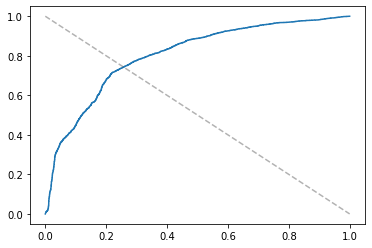

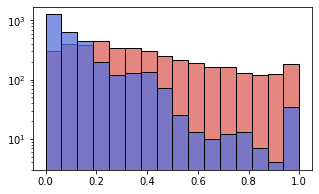

In [7]:

def result(label, score):  
    import sklearn.metrics as metrics
    fpr, tpr, thresholds = metrics.roc_curve(label, score)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    
    pred = (score >= thresholds[ix]).astype(np.float32)
    report = metrics.classification_report(label, pred, target_names=["normal", "abnormal"], output_dict=True)

    cm = metrics.confusion_matrix(label, pred)

    # create table of results
    empty = ''
    
    # PER CLASS STATISTICS
    iheader = f"Bug & Class & Precision  & Recall     & F1-score   & Support & True & False & $\mu(log\Delta_1)$ \\\\ \hline \n"
    # ("\multicolumn{5}{|c|}{" + bug_names[bug] + "} \\\\ \hline \n")\
    itable1 = f"{empty:20} & 0 (N) & {report['normal']['precision']:10.3f} & {report['normal']['recall']:10.3f} & {report['normal']['f1-score'] :10.3f} & {report['normal']['support'] :10} & {cm[0][0]:10} & {cm[0][1]:10} & {score[np.logical_not(label)].mean():10.3f} \\\\ \n"
    itable2 = f"{empty:20} & 1 (A) & {report['abnormal']['precision']:10.3f} & {report['abnormal']['recall']:10.3f} & {report['abnormal']['f1-score']:10.3f} & {report['abnormal']['support']:10} & {cm[1][1]:10} & {cm[1][0]:10} & {score[label].mean():10.3f} \\\\ \hline \n"
    itable = itable1 + itable2
    
    # CLASSIFICATION STATISTICS
    mheader = f"Bug & Threshold & G-Mean & PR AUC & PR NS & ROC AUC & Accuracy \\\\ \hline"
    mtable = f"{empty:20} & {thresholds[ix]:10.3f} & {gmeans[ix]:10.3f} & {metrics.average_precision_score(label, score):10.3f} & {(label.sum() / label.shape[0]):10.3f}  & {metrics.roc_auc_score(label, score) :10.3f} & {report['accuracy'] :10.3f} \\\\ \hline \n"
    
    return iheader, itable, mheader, mtable


def plot_hist(label, score):
    import seaborn as sb
    palette = sb.color_palette("hls", 8)
    RED, BLUE = palette[0], palette[5]
    
    # plot historgrams
    binrange = (score.min().item(), score.max().item())
    fig = plt.figure(figsize=(5,3))
    
    sb.histplot(score[label], color=RED, bins=16, binrange=binrange)
    ylim = plt.gca().get_ylim()
    sb.histplot(score[np.logical_not(label)], color=BLUE, bins=16, binrange=binrange)
    plt.gca().set_yscale('log')
    plt.gca().set_ylabel(None)
    return fig


def equal_error_rate(label, score):
    from scipy.optimize import brentq
    from scipy.interpolate import interp1d
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(label, score, pos_label=1)

    plt.plot(fpr, tpr)
    plt.plot([0,1],[1,0], color="black", alpha=0.3, linestyle="--")
   
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    #thresh = interp1d(fpr, thresholds)(eer)
    
    return eer

def proc_score(score, pscore, label):
    score = score.view(score.shape[0], -1).sum(-1)
    #score = torch.amax(score.view(score.shape[0], -1), -1)
    
    # remove sharp peaks that are due to camera glitches, this really messes with the averaging! it is a hack, we present results for with/without these artifacts
    #indx = pscore < 100. # remove 
    #shape = score.shape
    #score = score[indx]
    #label = label[indx]
    #pscore = pscore[indx]
    #print(shape, score.shape)
    
    #print(shape, score.shape)
    score = score.numpy()
    def averaging():
        kernel_size = 10
        swrap = np.zeros(score.shape[0] + kernel_size)
        #swrap[kernel_size:] = score[kernel_size//2:].mean() 
        #swrap[:-kernel_size] = score[:-kernel_size//2].mean()
        swrap[kernel_size:] = score[0]
        swrap[:-kernel_size] = score[1] 
        swrap[kernel_size//2:-kernel_size//2] = score
        kernel = np.ones(kernel_size + 1)
        return np.convolve(swrap, kernel, mode='valid')
    
    score = averaging()
    score = (score - score.min()) / (score.max() - score.min())
    return score, pscore.numpy(), label.numpy()
    
_scores, _pscores, _labels = zip(*[proc_score(*s) for s in zip(scores, pscores, labels)])
_scores, _pscores, _labels = np.concatenate(_scores), np.concatenate(_pscores), np.concatenate(_labels)

eer = equal_error_rate(_labels, _scores)
print(eer)
plot_hist(_labels, _scores)

iheader, itable, mheader, mtable = result(_labels, _scores)

print(iheader)
print(itable)
print(mheader)
print(mtable)






In [ ]:

for s  in zip(scores, pscores, labels):
    _scores, _pscores, _labels = proc_score(*s)
                                                          
    plt.figure()
    plt.hlines(0.399, 0, len(_scores)) # plot threshold
    plt.plot(_scores)
    plt.plot(_labels)

In [ ]:
_labels, _scores, = torch.cat(labels), torch.cat(pscores)

plt.figure(figsize=(16,3))
print(_scores.shape)
plt.plot(_scores)

indx = torch.argsort(-_scores)
print(_scores[indx][:10])



In [ ]:
_labels = []
_pscores = []

for (X1, X2), Y_ in tqdm(zip(X, Y)):
    pscore = ((X1.view(*X1.shape[:2], -1) - X2.view(*X1.shape[:2], -1)) ** 2).sum(-1)
    pscore = torch.amax(pscore, -1)
    _pscores.append(pscore)
    _labels.append(Y_)
                        
    break

_pscores, _labels = torch.cat(_pscores).numpy(), torch.cat(_labels).numpy()
print(_pscores.shape, _labels.shape)

plt.figure()
eer = equal_error_rate(_labels, _pscores)
print(eer)
plot_hist(_labels, _pscores)

iheader, itable, mheader, mtable = result(_labels, _pscores)

print(iheader)
print(itable)
print(mheader)
print(mtable)

